# **Library Book Recommendation System**
---
Authors: [Monicah Iwagit](https://github.com/Okodoimonicah), [Bradley Azegele](https://github.com/Azegele), [Emmanuel Kipkorir](), [Belinda Nyamai](), [Femi Kamau](https://github.com/ctrl-Karugu), and [Dennis Kimiri]()

## 1. Business Understanding

### 1.1 Problem Statement
>The tremendous growth and usage of information has led to information overloading where users find it difficult to locate the right information at a specified time. Although there are previous studies conducted on library recommender systems, the datasets used were small compared to the dataset we intend to use hence minimal area coverage. Recommending the right library books is a challenge due to the variety of genres available and the huge collection of books provided. A user finds it difficult to select the most appropriate book that will suit their academic needs, this process consumes a lot of time that the user would have used to sharpen on their desired skills. Additionally, many books in the library are rarely utilized which results in a waste of library resources. Having a personalized recommendation system seeks to predict the preference based on the user’s interest, behavior and information. The application of recommender systems in the university library solves the problem of difficulty in choosing books and improves utilization rate of library resources. 

## 2. Data Understanding
> The goal of the Data Understanding phase is to provide a solid foundation for the subsequent steps, including data preparation, exploratory data analysis, model development, and evaluation.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 2.1 Collect Initial Data
> The goal of this section is to acquire the necessary data and load it into the notebook.

> The data used in this project was sourced from 2 different sources:
>   1. The first was source was from Cai-Nicolas Ziegler in a 4-week crawl (August-September [2004]) in the University of Freiburg, Germany. This can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data obtained are 3 datasets with information on [users](./data/BX-Users.csv), [ratings](./data/BX-Book-Ratings.csv) and [books](./data/BX-Books.csv) from a library.
>
>   2. The second set of data was sourced from the [Google Books API](https://developers.google.com/books). This data was obtained by using ISBNs in the books dataset from the first source. The script used to extract the data can be found [here](./make_dataset.py). This data was then stored in csv format and can be found [here](./data/books.csv).

#### Load Data

In [2]:
# (Source 1)
ratings = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books = pd.read_csv("data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
users = pd.read_csv("data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="latin-1")

# (Source 2)
books_extra = pd.read_csv("data/books.csv", encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### 2.2 Describe Data
> The goal of this section is to examine the data and document its surface properties.

In [3]:
# Define class to describe the data 
class DescribeData():
    """This class is used to describe the data in a DataFrame."""
    
    def __init__(self, df) -> None:
        
        # Get the DataFrame
        self.df = df
        
        # Get the datatypes of the columns in the DataFrame
        self.datatypes = df.dtypes
         
        # Get the shape of the DataFrame
        self.shape = f"The shape of the DataFrame is {df.shape}\n\nRecords: {df.shape[0]}\nColumns: {df.shape[1]}"
        
        # Get the number of missing values in each column
        self.missing = f"There are a total of {df.isnull().sum().values.sum()} missing values in the DataFrame.\n\n{df.isnull().sum()}"
        
        # Get the number of duplicate rows
        self.duplicates = f"There are {df.duplicated().sum()} duplicated records in the DataFrame."

#### 2.2.1 `ratings`

In [4]:
# Create an instance of the 'DescribeData' class for the 'ratings' DataFrame
rt = DescribeData(ratings)

In [5]:
# Preview the 'ratings' DataFrame
rt.df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
# Inspect the information about the DataFrame
rt.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
# Inspect the shape of the DataFrame
print(rt.shape)

The shape of the DataFrame is (1149780, 3)

Records: 1149780
Columns: 3


In [8]:
# Inspect the datatypes of the columns in the DataFrame
print(rt.datatypes)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [9]:
# Inspect the summary statistics of the DataFrame
rt.df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [10]:
# Inspect the number of missing values in each column
print(rt.missing)

There are a total of 0 missing values in the DataFrame.

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [11]:
# Inspect the duplicates in the DataFrame
print(rt.duplicates)

There are 0 duplicated records in the DataFrame.


[**Ratings Dataset**](./data/BX-Book-Ratings.csv)

>* Spans **3** columns and **1,149,780** rows.

>* Contains **2** unique datatypes: 
>    * **int64**
>    * **object**

>* Has no missing values

>* Has no duplicates

#### 2.2.2 `books` 

In [12]:
# Instantiate the 'DescribeData' class for the 'books' DataFrame
bk = DescribeData(books)

In [13]:
# Preview the 'books' DataFrame
bk.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [14]:
# Inspect the information about the DataFrame
bk.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [15]:
# Inspect the shape of the DataFrame
print(bk.shape)

The shape of the DataFrame is (271360, 8)

Records: 271360
Columns: 8


In [16]:
# Inspect the datatypes of the columns in the DataFrame
print(bk.datatypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [17]:
# Inspect the missing values in the DataFrame
print(bk.missing)

There are a total of 6 missing values in the DataFrame.

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [18]:
# Inspect the duplicates in the DataFrame
print(bk.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books Dataset**](./data/BX-Books.csv)

>* Spans **8** columns and **271,359** rows.

>* Contains 1 unique datatype: 
>   * **object**

>* Has **6** missing values:
>   * Book-Author: **1** 
>   * Publisher: **2**
>   * Image-URL-L: **3**

>* Has no duplicates

#### 2.2.3 `users` 

In [19]:
# Instantiate the 'DescribeData' class for the 'users' DataFrame
ur = DescribeData(users)

In [20]:
# Preview the 'users' DataFrame
ur.df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [21]:
# Inspect the information about the DataFrame
ur.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [22]:
# Inspect the shape of the DataFrame
print(ur.shape)

The shape of the DataFrame is (278858, 3)

Records: 278858
Columns: 3


In [23]:
# Inspect the datatypes of the columns in the DataFrame
print(ur.datatypes)

User-ID       int64
Location     object
Age         float64
dtype: object


In [24]:
# Inspect the summary statistics of the DataFrame
ur.df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [25]:
# Inspect the missing values in the DataFrame
print(ur.missing)

There are a total of 110762 missing values in the DataFrame.

User-ID          0
Location         0
Age         110762
dtype: int64


In [26]:
# Inspect the duplicates in the DataFrame
print(ur.duplicates)

There are 0 duplicated records in the DataFrame.


[**Users Dataset**](./data/BX-Users.csv)

>* Spans **3** columns and **278,857** rows.

>* Contains **3** unique datatypes:
>   * **int64**
>   * **float64**
>   * **object**

>* Has **110762** missing values:
>   * Age: **110,762**

>* Has no duplicates

#### 2.2.4 `books_extra`

In [27]:
# Instantiate the 'DescribeData' class for the 'books_extra' DataFrame
bk_extra = DescribeData(books_extra)

In [28]:
# Preview the 'books_extra' DataFrame
bk_extra.df.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [29]:
# Inspect the information about the DataFrame
bk_extra.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188041 entries, 0 to 188040
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   authors          144197 non-null  object 
 1   published_date   145394 non-null  object 
 2   description      125110 non-null  object 
 3   isbn_10          145436 non-null  object 
 4   isbn_13          123579 non-null  object 
 5   page_count       144659 non-null  float64
 6   categories       136636 non-null  object 
 7   maturity_rating  145444 non-null  object 
 8   language         145444 non-null  object 
 9   join_isbn_10     188040 non-null  object 
dtypes: float64(1), object(9)
memory usage: 14.3+ MB


In [30]:
# Inspect the shape of the DataFrame
print(bk_extra.shape)

The shape of the DataFrame is (188041, 10)

Records: 188041
Columns: 10


In [31]:
# Inspect the datatypes of the columns in the DataFrame
print(bk_extra.datatypes)

authors             object
published_date      object
description         object
isbn_10             object
isbn_13             object
page_count         float64
categories          object
maturity_rating     object
language            object
join_isbn_10        object
dtype: object


In [32]:
# Inspect the summary statistics of the DataFrame
bk_extra.df.describe()

,page_count
count,144659.000000
mean,284.554801
std,176.874521
min,0.000000
25%,182.000000
50%,264.000000
75%,364.000000
max,3591.000000


In [33]:
# Inspect the missing values in the DataFrame
print(bk_extra.missing)

There are a total of 436471 missing values in the DataFrame.

authors            43844
published_date     42647
description        62931
isbn_10            42605
isbn_13            64462
page_count         43382
categories         51405
maturity_rating    42597
language           42597
join_isbn_10           1
dtype: int64


In [34]:
# Inspect the duplicates in the DataFrame
print(bk_extra.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books (Extra) Dataset**](./data/books.csv)

>* Spans **10** columns and **()** rows.

>* Contains **2** unique datatypes:
>   * **float64**
>   * **object**

>* Has **()** missing values:

>* Has no duplicates

## 3. Data Preparation
> The goal of the Data Preparation phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling.

### 3.1 data selection
This involves choosing the relevant data that will be used for a particular analysis or task by either, selecting a subset of columns, filtering rows, sampling, combining datasets, etc

* In the **books dataset** we drop 3 columns, the image urls since they won't be needed for our analysis

In [35]:
# class for droping columns that are not needed

class drop_column:
    def __init__(self, data):
        self.data = data

    def drop_columns(self, columns):
        self.data = self.data.drop(columns, axis=1)
        return self.data

In [36]:
# droping image-urls from the books dataset

drop = drop_column(books)
books = drop.drop_columns(['Image-URL-S', 'Image-URL-M'])
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


* we then merge **books** and **extra_books** datasets.

In [37]:
# merging the books dataset and books_extra dataset

books_data = books.merge(books_extra, left_on='ISBN', right_on='join_isbn_10', how='inner')
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182629 entries, 0 to 182628
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 182629 non-null  object 
 1   Book-Title           182629 non-null  object 
 2   Book-Author          182629 non-null  object 
 3   Year-Of-Publication  182629 non-null  object 
 4   Publisher            182627 non-null  object 
 5   Image-URL-L          182628 non-null  object 
 6   authors              144196 non-null  object 
 7   published_date       145393 non-null  object 
 8   description          125109 non-null  object 
 9   isbn_10              145436 non-null  object 
 10  isbn_13              123579 non-null  object 
 11  page_count           144659 non-null  float64
 12  categories           136636 non-null  object 
 13  maturity_rating      145444 non-null  object 
 14  language             145444 non-null  object 
 15  join_isbn_10     

In [38]:
# data understanding of the new dataset
bd = DescribeData(books_data)

In [39]:
# inspecting shape of the dataframe
print(bd.shape)

The shape of the DataFrame is (182629, 16)

Records: 182629
Columns: 16


In [40]:
# Inspect the duplicates in the DataFrame
print(bd.duplicates)

There are 0 duplicated records in the DataFrame.


In [41]:
# Inspect the missing values in the DataFrame
print(bd.missing)

There are a total of 387768 missing values in the DataFrame.

ISBN                       0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  2
Image-URL-L                1
authors                38433
published_date         37236
description            57520
isbn_10                37193
isbn_13                59050
page_count             37970
categories             45993
maturity_rating        37185
language               37185
join_isbn_10               0
dtype: int64


* The resulting dataset **books_data** contains 2 unique dtypes:

  * **object**
  * **float**

### 3.2 data cleaning
Is the process of identifying and correcting or removing incorrect, incomplete, or improperly formatted data in a dataset.
This involves handling missing values, fixing incorrect data, removing duplicates, normalizing data and handling outliers.

#### 3.2.1 In **ratings**:

we check to see that all entries in the book-rating are integers 

In [42]:
# function to check if all entries in the column are integers

def check_int(df, column_name):
    
    if df[column_name].apply(lambda x: isinstance(x, int)).all():
    
    
      print("All entries in the column are integers.")
    
    else:
        
        print("Not all entries in the column are integers.")

In [43]:
# if entries in book-rating column are integers

check_int(ratings, 'Book-Rating')

All entries in the column are integers.


In [44]:
# if entries in user-id column are integers

check_int(ratings, 'User-ID')

All entries in the column are integers.


In [45]:
# checking whether any of the values in the ISBN column of the ratings dataframe contain any characters 
# that are not alphabetical or numerical.

import  re 


# Define a regular expression to match non-alphanumeric characters
reg = "[^A-Za-z0-9]"

# Initialize a flag variable
flag = 0

# Loop through each value in the ISBN column
for x in ratings['ISBN']:
  # Check if the value contains any non-alphanumeric characters
  if re.search(reg, x):
    # If any are found, set the flag variable to 1
    flag = 1
    break

# Check the value of the flag variable
if flag == 1:
    print("There are non-alphanumeric characters in the ISBN column.")
else:
    print("There are no non-alphanumeric characters in the ISBN column.")    

There are non-alphanumeric characters in the ISBN column.


#### 3.2.2 In **users**:

The location column has city, state and country separated by commas. We segregate these into 3 different columns so that we can analyse on the basis of the country of different users


In [46]:
#splitting a string into a list
list_ = users.Location.str.split(', ')
#empty lists to add values
city = []
state = []
country = []
count_no_state = 0
count_no_country = 0
#generating a for loop to add values to the empty lists
for i in range(0,len(list_)):
    #removing invalid entries in city
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':
        city.append('other')
    else:
        city.append(list_[i][0].lower())
    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        #removing invalid entries in state
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':
            state.append('other')
            count_no_state += 1
        else:
            state.append(list_[i][1].lower())
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            #removing invalid entries in country
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
#dropping the location column from users
users = users.drop('Location',axis=1)
#handling cases where city/state from the lists is already given
temp = []
for ent in city:
    c = ent.split('/')
    temp.append(c[0])
#creating a dataframe for city, state and country
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])
#adding the new dataframes to the original users dataframe
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)
#printing the number of countries that do not have values
print(count_no_country)
#printing the states which didnt have any values
print(count_no_state)

4659
16044


In [47]:
# preview users

users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [48]:
# unique values in age 
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

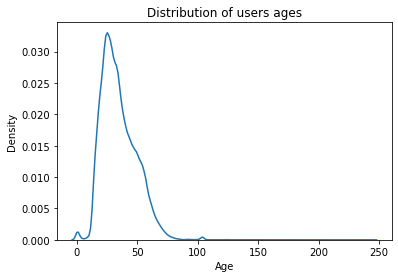

In [49]:
# Create a density plot to show the distribution of ages
sns.kdeplot(users['Age'])

# Add a title and labels to the x and y axes
plt.title('Distribution of users ages')
plt.xlabel('Age')
plt.ylabel('Density')

# Show the plot
plt.show()

* For our book recommendation system, users with ages less than 10 and above 80 are not the appropriate target for our system and we assume that they will not be able to access a library or use the recommendation system.

* Looking at the distribution plot the age is skewed to the right and has outliers. Replacing the missing age values and values less than 10 and greater than 80 witih the median will be the robust approach since it's not sensitive to extreme values compared to using the mean. 

In [50]:
# checking for null values
users['Age'].isnull().sum()

110762

In [51]:
# Select rows where the age column is greater than 10 and less than 80
users_filtered = users[(users['Age'] > 10) & (users['Age'] < 80)]

In [52]:
median = users_filtered['Age'].median()
median

32.0

In [53]:
# Replace the entries less than 10 or greater than 80 with the median
users.loc[(users['Age'] < 10) | (users['Age'] > 80), 'Age'] = median

In [54]:
# Replace missing values in the "age" column with the median age
users['Age'] = users['Age'].fillna(median)

In [55]:
# checking for null values
users['Age'].isnull().sum()

0

### 3.2.3 **books_data** (merged books and extra_books)

In [56]:
# define class for data cleaning
class DataCleaning:
    def __init__(self, data):
        self.data = data
        
    def drop_null_rows(self):
        """Drops rows with null values."""
        self.data = self.data.dropna()
        return self.data

    def drop_duplicate_rows(self):
        """Drops duplicate rows."""
        self.data = self.data.drop_duplicates()
        return self.data

    def handle_missing_values(self, column, method, value=None):
        """Handles missing values in a specified column.
        
        The method parameter take one of the following:
        "drop": Drops rows with missing values in the specified column.
        "fill": Fills missing values with the specified value.
        "interpolate": Interpolates missing values using linear interpolation.
        """
        if method == "drop":
            self.data = self.data.dropna(subset=[column])
        elif method == "fill":
            self.data[column] = self.data[column].fillna(value)
        elif method == "interpolate":
            self.data[column] = self.data[column].interpolate()
        else:
            raise ValueError("Invalid value for method parameter. Valid values are 'drop', 'fill', and 'interpolate'.")
        return self.data

    def convert_column_data_type(self, column, data_type):
        """Converts the data type of a specified column."""
        self.data[column] = self.data[column].astype(data_type)
        return self.data

In [57]:
data_cleaning = DataCleaning(books_data)

In [58]:
# dropping columns that will not be needed for our analysis
books_data.drop(columns=['isbn_10', 'isbn_13', 'join_isbn_10'], axis=1, inplace=True)

In [59]:
# Drop rows with null values in the "description" column

books_data = data_cleaning.handle_missing_values(column="description", method="drop")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en


* we drop all entries with no description, because it is a crutial feature that will be used in our recommendation system.

In [60]:
# Inspect the missing values in the DataFrame
books_data.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-L               1
authors                 885
published_date           13
description               0
page_count              323
categories             2552
maturity_rating           0
language                  0
dtype: int64

In [61]:
#unique year of publication
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1942, 1939, 2030, 1949, 1932, 1929, 1923, 1927, 1936, 1931,
       1938, 1914, 1910, 1943, 1933, 1911, 1902, 2038, 2010, 1901, 1921,
       '2002', '1993', '1991', '2001', '1999', '1990', '0', '1995',
       '1987', '1978', '1985', '1969', '1994', '1989', '1992', '2004',
       '2000', '1979', '1976', '2003', '1975', '1997', '1996', '1973',
       '1998', '1984', '1983', '1971', '2006', '1980', '1988', '1977',
       '1981', '1974', '1968', '1982', '1961', '1986', '1970', '1960',
       '1967', '1966', '1964', '1955', '1951', '1965', '1959', '197

In [62]:
#inspecting the row having year of publication as author 
books_data.loc[books_data['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
177764,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,NaN,['Michael Teitelbaum'],2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en


In [63]:
#correcting the book author and year of publication
books_data.loc[177764, 'Publisher'] = 'DK Publishing Inc'
books_data.loc[177764, 'Year-Of-Publication'] = 2000
books_data.loc[177764, 'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books_data.loc[177764, 'Book-Author'] = 'James Buckley'

In [64]:
# preview
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1942, 1939, 2030, 1949, 1932, 1929, 1923, 1927, 1936, 1931,
       1938, 1914, 1910, 1943, 1933, 1911, 1902, 2038, 2010, 1901, 1921,
       '2002', '1993', '1991', '2001', '1999', '1990', '0', '1995',
       '1987', '1978', '1985', '1969', '1994', '1989', '1992', '2004',
       '2000', '1979', '1976', '2003', '1975', '1997', '1996', '1973',
       '1998', '1984', '1983', '1971', '2006', '1980', '1988', '1977',
       '1981', '1974', '1968', '1982', '1961', '1986', '1970', '1960',
       '1967', '1966', '1964', '1955', '1951', '1965', '1959', '197

In [65]:
books_data.shape

(125109, 13)

* from above we see that the data type of the year of publication are not consistently integers. 

In [66]:
# converting Year-Of-Publication to integers
books_data = data_cleaning.convert_column_data_type('Year-Of-Publication', int)
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
          0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1942, 1939, 2030, 1949, 1932, 1929, 1923, 1927, 1936, 1931,
       1938, 1914, 1910, 1943, 1933, 1911, 1902, 2038, 2010, 1901, 1921,
       2006, 1944])

In [67]:
# checking on rows with year of publication as 0
books_data.loc[books_data['Year-Of-Publication'] == 0]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
502,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra,P Coelho,0,Fabbri - RCS Libri,http://images.amazon.com/images/P/8845229041.01.LZZZZZZZ.jpg,['Paulo Coelho'],1996,"Pilar ritrova a Madrid l'amico dell'infanzia. Questi ha girato il mondo ed ÃÂ¨ poi entrato in seminario, dove si dice abbia fatto miracoli. Pilar ÃÂ¨ una donna passionale, ma delusa dalla vita. Con l'amico d'infanzia compie un viaggio di sei giorni durante il quale la donna ritrova se stessa attraverso una riflessione mistico-iniziatica. I due si recano a Lourdes dove cementeranno il loro amore alla luce di una fede che esalta i valori della missione nel mondo.",216.0,['Fiction'],NOT_MATURE,it
606,0590021117,Little House On the Prairie,Laura Ingall Wilder,0,Scholastic Inc,http://images.amazon.com/images/P/0590021117.01.LZZZZZZZ.jpg,['Laura Ingalls Wilder'],1953,"A family travels from the big woods of Wisconsin, to a new home on the praire, where they build a house, meet neighboring Indians, build a well, and fight a praire fire.",221.0,['Families'],NOT_MATURE,en
688,2070362388,Ravage,Rene Barjavel,0,Gallimard French,http://images.amazon.com/images/P/2070362388.01.LZZZZZZZ.jpg,['RenÃÂ© Barjavel'],1972,"De l'autre cÃÂ´tÃÂ© de la Seine une coulÃÂ©e de quintessence enflammÃÂ©e atteint, dans les sous-sols de la caserne de Chaillot, ancien TrocadÃÂ©ro, le dÃÂ©pÃÂ´t de munitions et le laboratoire de recherches des poudres. Une formidable explosion entrouvre la colline. Des pans de murs, des colonnes, des rochers, des tonnes de dÃÂ©bris montent au-dessus du fleuve, retombent sur la foule agenouillÃÂ©e qui rÃÂ¢le son adoration et sa peur fendent les crÃÂ¢nes, arrachent les membres, brisent les os. Un ÃÂ©norme bloc de terre et de ciment aplatit d'un seul coup la moitiÃÂ© des fidÃÂ¨les de la paroisse du Gros-Caillou. En haut de la Tour, un jet de flammes arrache l'ostensoir des mains du prÃÂªtre ÃÂ©pouvantÃÂ©.",313.0,['Fiction'],NOT_MATURE,fr
692,2266033689,Le Diable Au Corps,Raymond Radiguet,0,Presses Pocket French,http://images.amazon.com/images/P/2266033689.01.LZZZZZZZ.jpg,['Raymond Radiguet'],1990,"Pendant la premiÃÂ¨re guerre mondiale, FranÃÂ§ois, un lycÃÂ©en, fait la connaissance de Marthe, une jeune femme de dix-huit ans. Celle-ci est fiancÃÂ©e ÃÂ Jacques, un soldat qui se bat sur le front. Au mÃÂ©pris des commÃÂ©rages, FranÃÂ§ois et Marthe vont devenir amants. Mais FranÃÂ§ois n'est-il pas trop jeune pour s'engager dans une telle liaison ?",206.0,NaN,NOT_MATURE,fr
757,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd,http://images.amazon.com/images/P/0718144538.01.LZZZZZZZ.jpg,['Dick Francis'],2000,"Gerard Logan finds that when his jockey friend dies following a fall at the Cheltenham races, he is involved in a desperate search for a stolen video tape which embroils him in more life-threatening hazards than does his work as a widely-acclaimed glass-blower.",271.0,['Detective and mystery stories'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181740,076070712X,Encyclopedia of the Worlds Religions,R D Zaehner,0,Barnes Noble Books,http://images.amazon.com/images/P/076070712X.01.LZZZZZZZ.jpg,['Robert Charles Zaehner'],1997,"Covers many world religions such as Judaism, Christianity, Islam, Zoroastrianism, Hinduism, Jainism, Buddhism, Shinto, Confucianism, Taoism, Sikhism, Dialectical meterialism, etc.",472.0,['Religions'],NOT_MATURE,en
182263,225303956x,Adieu Volodia,Simone Signoret,0,Livre De Poche French,http://images.amazon.com/images/P/225303956X.01.LZZZZZZZ.jpg,['Simone Signoret'],1985,"Au 58, rue de la Mare, dans le XXe arrondissement de Paris, vivent les Guttman et les Roginski. Fuyant l'horreur des pogroms, les deux couples sont venus, l'un d'Ukraine en 1919, l'autre de Pologne en 1921 et ont eu chacun un enfant : Maurice et Elsa. 

* we have a total of 1438 rows that lack the Year-Of-Publication, but looking at the published date we can obtain the Year-Of-Publication.

In [68]:
#def replace_year_of_publication(data):
    # Extract the year from the "published-date" column and convert it to an integer
    #data["published-year"] = pd.to_datetime(data["published_date"]).dt.year.astype(int)
    
    # Replace values where the "Year-Of-Publication" is 0 with the corresponding value in the "published-data" column
    #data["Year-Of-Publication"] = data["Year-Of-Publication"].mask(data["Year-Of-Publication"] == 0, data["published-year"])

# Replace the values where the "Year-Of-Publication" is 0
#replace_year_of_publication(books_data)


In [69]:
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
          0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1942, 1939, 2030, 1949, 1932, 1929, 1923, 1927, 1936, 1931,
       1938, 1914, 1910, 1943, 1933, 1911, 1902, 2038, 2010, 1901, 1921,
       2006, 1944])

In [70]:
# Checking for missing values in publisher column

books_data.loc[books_data['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
120762,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg,['Linnea Sinclair'],2001-10,"Be careful what you wish for. You might get it... Her ship's in shambles, her boyfriend's dumped her and she's frankly out of funds. Captain Trilby Elliot hopes her luck has changed when a high-tech fightercraft crash lands at her repair site. Finders keepers. She can sell the ship as salvage, pocket the profits. Except for one small problem: the pilot, Rhis, is still alive and intent on commandeering her ship. And another much larger problem: someone very powerful and very important wants Trilby Elliot dead.",354.0,['Fiction'],NOT_MATURE,en


* Publisher column has one entry with NaN. To deal with this we do a websearch using the isbn number and book title to obtain the publisher.

In [71]:
# inputting the correct publisher on the row with NaN

books_data.loc[120762, 'Publisher'] = 'Novelbooks Incorporated'

In [72]:
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125109 entries, 0 to 182628
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 125109 non-null  object 
 1   Book-Title           125109 non-null  object 
 2   Book-Author          125109 non-null  object 
 3   Year-Of-Publication  125109 non-null  int32  
 4   Publisher            125109 non-null  object 
 5   Image-URL-L          125108 non-null  object 
 6   authors              124224 non-null  object 
 7   published_date       125096 non-null  object 
 8   description          125109 non-null  object 
 9   page_count           124786 non-null  float64
 10  categories           122557 non-null  object 
 11  maturity_rating      125109 non-null  object 
 12  language             125109 non-null  object 
dtypes: float64(1), int32(1), object(11)
memory usage: 17.9+ MB


In [73]:
# In the authors column we have the authors names in a list
# Remove the brackets and quotation marks from the 'authors' column
books_data['authors'] = books_data['authors'].str.strip('[]')
books_data['authors'] = books_data['authors'].str.strip("''")

# preview data set
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Mark P. O. Morford', 'Robert J. Lenardon",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"""Carlo D'Este""",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,Gina Bari Kolata,1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,E. J. W. Barber,1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,Amy Tan,1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en


In [74]:
# checking for missing data in authors
books_data['authors'].isna().sum()

885

* we use the book_author column to replace the 885 missing values in the aurthors column

In [75]:
# fuction to handle missing data in authors column
def replace_missing_values(df):
    # Create a boolean mask indicating which rows in the "authors" column have missing values
    mask = df['authors'].isnull()
    
    # Get the index values for the rows where the value in the "authors" column is missing
    indexes = df.loc[mask, 'authors'].index
    
    # Use the index values to select the corresponding values in the "book_authors" column
    # and assign these values to the "authors" column for the rows where the value is missing
    df.loc[indexes, 'authors'] = df.loc[indexes, 'Book-Author']

In [76]:
# replacing missing authors with corresponding book-author
replace_missing_values(books_data)

In [77]:
# rechecking for missing values in authors
books_data['authors'].isna().sum()

0

In [78]:
# drop book-author column
books_data.drop('Book-Author', axis=1, inplace=True)

* The category column has the categories in list. correct this by removing the brackets and quotations

In [79]:
# In the categories column we have the categories names in a list
# Remove the brackets and quotation marks from the 'categories' column
books_data['categories'] = books_data['categories'].str.strip('[]')
books_data['categories'] = books_data['categories'].str.strip("''")

# preview data set
books_data.head()

,ISBN,Book-Title,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Mark P. O. Morford', 'Robert J. Lenardon",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"""Carlo D'Este""",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,1940-1949,NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,Gina Bari Kolata,1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,Medical,NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,E. J. W. Barber,1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,Design,NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,Amy Tan,1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,Fiction,NOT_MATURE,en


* we have page_count as float, convert it to an integer
* replace missing values with a placeholder, -1

In [80]:
# Convert the 'page_count' to numeric data type
books_data['page_count'] = pd.to_numeric(books_data['page_count'], errors='coerce')

# Replace any NaN values with a placeholder value
books_data['page_count'].fillna(-1, inplace=True)

# Convert the 'float_column' to integer data type
books_data['page_count'] = books_data['page_count'].round().astype(int)

# preview data set
books_data.head()

,ISBN,Book-Title,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Mark P. O. Morford', 'Robert J. Lenardon",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"""Carlo D'Este""",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,Gina Bari Kolata,1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,E. J. W. Barber,1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,Design,NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,Amy Tan,1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428,Fiction,NOT_MATURE,en


In [81]:
#inspecting page_count entries with missing data with the placeholder -1
books_data.loc[books_data['page_count'] == -1,:]

,ISBN,Book-Title,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
41,055321215X,Pride and Prejudice,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.LZZZZZZZ.jpg,Jane Austen,1983-12-01,"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",-1,NaN,NOT_MATURE,en
279,0394586239,Possession: A Romance,1990,Random House Inc,http://images.amazon.com/images/P/0394586239.01.LZZZZZZZ.jpg,Antonia Susan Byatt,2004,"In 1986 two young English scholars stumble upon a remarkable discovery: a hitherto unsuspected relationship between the Browningesque 19th century poet Randolph Henry Ash, and his contemporary Christabel LaMotte. Their research reveals uncanny parallels with their own lives and culminates in the exhumation of a poet's corpse.",-1,Biographers,NOT_MATURE,en
2502,0671705997,Easy to Kill,1991,Pocket Books,http://images.amazon.com/images/P/0671705997.01.LZZZZZZZ.jpg,Agatha Christie,1990-12,"An elderly lady suspected of murder in the sleepy village of Wychwood dies--another victim of an unseen hand. Since too many accidents and unexplained deaths have occurred, even for a town with a history of witchcraft, policeman Luke Fitzwilliam vows to discover the reason--and finds a very cunning killer.",-1,NaN,NOT_MATURE,en
2693,0671743562,"Dreams of the Raven (Star Trek, No 34)",1991,Star Trek,http://images.amazon.com/images/P/0671743562.01.LZZZZZZZ.jpg,Carmen Carter,1991-09-01,Captain Kirk and the crew of the Enterprise struggle against an unknown deadly enemy after a mysterious attack cripples the starship and leaves Dr. McCoy without a memory,-1,Fiction,NOT_MATURE,en
4654,0425043231,Man in a High Castle,1979,Berkley Publishing Group,http://images.amazon.com/images/P/0425043231.01.LZZZZZZZ.jpg,Philip K. Dick,1979-05-15,"It's America in 1962. Slavery is legal once again. the few Jews who still survive hide under assumed names. In San Francisco the I Ching is as common as the Yellow Pages. All because some 20 years earlier the United States lost a war--and is now occupied jointly by Nazi Germany and Japan. This harrowing, Hugo Award-winning novel is the work that established Philip K. Dick as an innovator in science fiction while breaking the barrier between science fiction and the serious novel of ideas. In it Dick offers a haunting vision of history as a nightmare from which it may just be possible to awake.",-1,NaN,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
180426,0671479849,The Carpetbaggers,1983,Pocket,http://images.amazon.com/images/P/0671479849.01.LZZZZZZZ.jpg,Harold Robbins,1983-08-02,"This legendary masterpiece--the most successful of Robbins's many books--tells a story of money and power, sex and death, and is available once again in an exciting new package. Reissue.",-1,NaN,NOT_MATURE,en
180689,0449215776,This Rough Magic,1989,Fawcett Books,http://images.amazon.com/images/P/0449215776.01.LZZZZZZZ.jpg,Mary Stewart,1987-11-01,Lucy becomes entangled in a mystery when her desire to meet John Gale the actor is hindered by his son,-1,Fiction,NOT_MATURE,en
180754,18

* There are 323 missing values in page_count.

In [82]:
books_data.isna().sum()

ISBN                      0
Book-Title                0
Year-Of-Publication       0
Publisher                 0
Image-URL-L               1
authors                   0
published_date           13
description               0
page_count                0
categories             2552
maturity_rating           0
language                  0
dtype: int64

In [83]:
# function to convert column names to lower case
def lowercase_column_names(df):
    # Get a list of the column names, and convert each one to lower case
    lowercase_columns = [x.lower() for x in df.columns]
    
    # Replace the existing column names with the lower case version
    df.columns = lowercase_columns

In [84]:
# Convert the column names to lower case
lowercase_column_names(books_data)


In [85]:
books_data.head()

,isbn,book-title,year-of-publication,publisher,image-url-l,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Mark P. O. Morford', 'Robert J. Lenardon",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"""Carlo D'Este""",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,Gina Bari Kolata,1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,E. J. W. Barber,1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,Design,NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,Amy Tan,1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428,Fiction,NOT_MATURE,en
